In [1]:
import numpy
import h5py

from toposample import Config, data
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from figure_helper import FigureHelper

"""
Main config file. This file specifies the paths to all the result files and allows us to read the results.
"""
cfg = Config("../working_dir/config/common_config.json")

"""
Additional parameterization, like which examples to plot and in which color
"""
stim_colors = ["maroon", "red", "orange", "green", "teal", "purple", "blue", "turquoise"]
exemplary_tribes = {"Figure-S2": {"sampling": "Radius",
                                  "specifier": "175 um",
                                  "index": "4"},
                    "Figure-S3": {"sampling": "Radius"},
                    "Panel-A": {"sampling": "Radius",
                                  "specifier": "175 um",
                                  "index": "4"},
                    "Panel-B": {"sampling": "Radius",
                                  "specifier": "175 um"},
                    "Panel-C": {"sampling": "Radius",
                                  "specifier": "175 um"}
                   }
# For Figure-2/Panel-A
components_to_plot_b = [7, 8, 9]
components_to_plot_a = [1, 2, 3]
min_to_plot_variability = 0.004
# For Figure2/Panel-B
interesting_indices = numpy.array(["0", "1", "2", "3", "4", "5"])

"""
To save plots in standardized locations, i.e. under ./figures
"""
fhlpr = FigureHelper()


In [2]:
"""
LOADING THE DATA...
Location of relevant data is looked up from the main config file.
"""
components_fn = cfg._cfg['analyzed']['components']
accuracy_fn = cfg._cfg['analyzed']['classifier_manifold_results']
num_stimuli = cfg.stage("split_spikes")["config"]["num_stimuli"]
num_components = cfg.stage("manifold_analysis")["config"]["n_components"]


"""
Then we can load it.
"""
per_stim_read_fun = data.read_multiple_h5_datasets(dict([("stim{0}".format(i),
                                                          "per_stimulus/stim{0}".format(i))
                                                         for i in range(num_stimuli)]))
score_read_fun = data.read_h5_dataset("scores")
components_main = data.TopoData(components_fn, follow_link_functions={"data_fn": [per_stim_read_fun, True]})
accuracy_data = data.TopoData(accuracy_fn,
                              follow_link_functions={"data_fn": [score_read_fun, True]})["data_fn"]
comp_data = components_main["data_fn"]
comp_parent = components_main["idv_label"] # not used..?

In [3]:
"""
Once loaded, the data can be looked up by "sampling", "specifier" and "index" from comp_data.
Each data point is a dict with stimulus identity as key and the value has the shape time x components x trials.

Instead we want to turn the stimulus identity and component into additional conditions that can be used to look 
up data from comp_data. To do that we use the "unpool" function that allows us to define additional dimensions.
We use "unpool" with a custom function that splits the data by stimulus and component.
"""
def make_stimulus_and_component_condition(data):
    for k, v in data.res.items():
        for comp in range(v.shape[1]):
            yield v[:, comp, :], {"stimulus": k, "component": comp} # time x trials

comp_data.unpool(make_stimulus_and_component_condition)

for cond in comp_data.conditions():
    print("{0}:\n\t{1}".format(cond, comp_data.labels_of(cond)))


IOPub message rate exceeded.                                                   
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



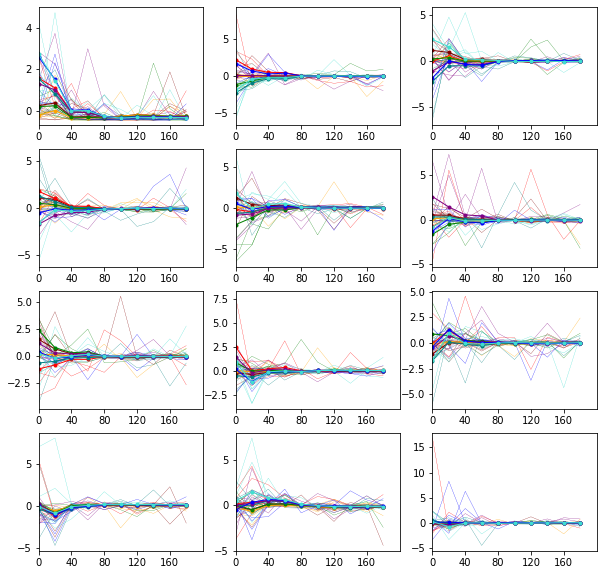

In [4]:
fig = plt.figure(figsize=(10, 10))
S = fhlpr("Figure-S2")
exemplary_tribe = exemplary_tribes["Figure-S2"]

data_points = comp_data.filter(**exemplary_tribe)

for comp in data_points.labels_of("component"):
    ax = fig.add_subplot(4, 3, comp + 1) # hard coded for 12 components =(
    for col, stim in zip(stim_colors, data_points.labels_of("stimulus")):
        x_data = data_points.get2(stimulus=stim, component=comp).transpose()
        mn_data = x_data.mean(axis=0)
        sem_data = numpy.std(x_data, axis=0) / numpy.sqrt(x_data.shape[0])
        ax.errorbar(range(len(mn_data)), mn_data, yerr=sem_data, color=col, marker='o', ms=3, lw=1.0)
        sel_idx = numpy.random.choice(x_data.shape[0], numpy.minimum(5, x_data.shape[0]), replace=False)
        for sel_data in x_data[sel_idx]:
            ax.plot(range(len(sel_data)), sel_data,
                    lw=0.25, ms=2, color=col)
    ax.set_xticks([0, 2, 4, 6, 8])
    ax.set_xticklabels([0, 40, 80, 120, 160])
    ax.set_xlim([0, 10])
S.save(fig, fn="index-{0}".format(exemplary_tribe["index"]))

/mnt/c/Users/reima/Documents/code/topological_sampling/notebooks/component_reacts_to_novelty.py:10: RuntimeWarning: divide by zero encountered in true_divide
  func = lambda v, t: initial_value * numpy.exp(-t / v)
/mnt/c/Users/reima/Documents/code/topological_sampling/notebooks/component_reacts_to_novelty.py:10: RuntimeWarning: invalid value encountered in true_divide
  func = lambda v, t: initial_value * numpy.exp(-t / v)


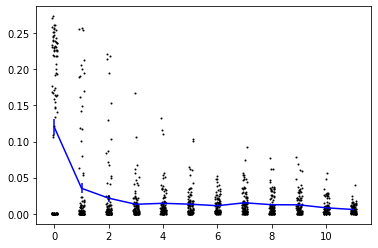

In [5]:
"""
Here, we evaluate the idea that the first component just tends to respond to novelty, i.e. it shoots up 
whenever there's a new stimulus, independent of stimulus identity. 

For evaluation we formulate a model where a component goes up in the first time step of a new stimulus to a fixed
value and then exponentially decays. We then fit that model to the data and see what fraction of the variance it
explains (we load that from 'component_reacts_to_novelty.py').
"""
from component_reacts_to_novelty import eval_reacts_to_novelty_model
S = fhlpr("Figure-S3")
exemplary_tribe = exemplary_tribes["Figure-S3"]

data_points = comp_data.filter(**exemplary_tribe)

def ordered_stack(x, y, out_fun=numpy.array):
    idx = numpy.argsort(x)
    return out_fun([y[i] for i in idx])

# By pooling over all stimuli, we can evaluate to what degree a component fits the 'novelty' model
novelty_alignment = data_points.pool(['stimulus'], func=eval_reacts_to_novelty_model)
# Now we pool the results for all comoponents of a sample together into an array for plotting
novelty_alignment = novelty_alignment.pool(['component'], func=ordered_stack, xy=True)
ax = plt.gca()
# Get results for all sampling strategies and specifications
I = numpy.vstack(novelty_alignment.get())
for i in I:
    ax.plot(numpy.arange(len(i)) + 0.2*(numpy.random.rand() - 0.5), i,
            marker='.', ls='None', color='black', ms=2)
ax.errorbar(range(len(i)), numpy.mean(I, axis=0), yerr=numpy.std(I, axis=0) / numpy.sqrt(I.shape[0]), color='blue')
S.save(plt.gcf())

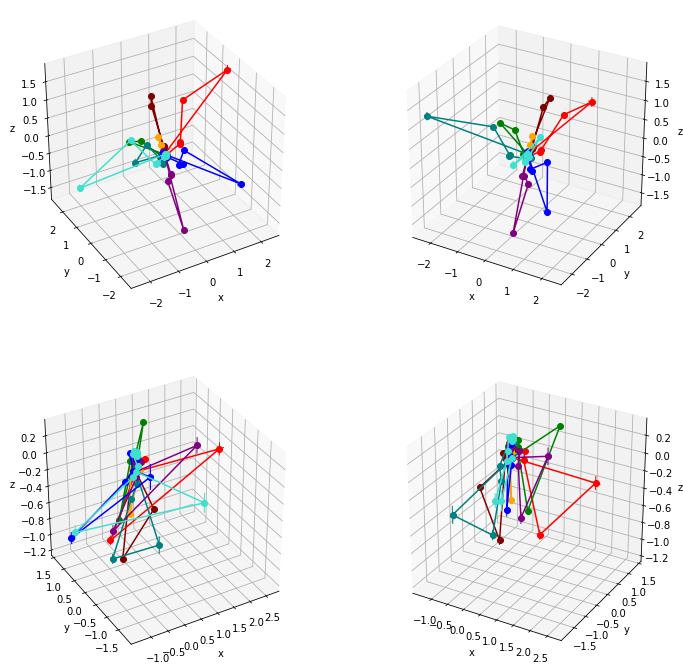

In [6]:
"""
Here, we simply plot the average trajectories of some exemplary components in 3d coordinate systems.
We plot two selections of components and provide two views (from different angles) of each of them.
"""
fig = plt.figure(figsize=(12, 12))
S = fhlpr("Figure-2")
exemplary_tribe = exemplary_tribes["Panel-A"]

data_points = comp_data.filter(**exemplary_tribe)

def plot_selected_components(components_to_plot, two_axes):
    def plot_func(ax):
        for col, stim in zip(stim_colors, data_points.labels_of("stimulus")):
            x_data = [data_points.get2(stimulus=stim, component=comp)
                      for comp in components_to_plot] # [component] x time_steps x trials
            mn_data = numpy.vstack([_x.mean(axis=1) for _x in x_data]) # component x time_steps
            ax.plot(numpy.hstack([0, mn_data[0]]),
                    numpy.hstack([0, mn_data[1]]),
                    numpy.hstack([0, mn_data[2]]),
                    marker='o', color=col)
            for idx, val in enumerate(mn_data.transpose()): # for each time step
                if numpy.sqrt(numpy.sum(val ** 2)) >= min_to_plot_variability:
                    sem_data = numpy.array([numpy.std(_x[idx, :]) / numpy.sqrt(_x.shape[1])
                                            for _x in x_data]) # components
                    z = numpy.zeros(2)
                    ax.plot(mn_data[0, idx] + numpy.array([-sem_data[0], sem_data[0]]),
                           mn_data[1, idx] + z,
                           mn_data[2, idx] + z, color=col, lw=1)
                    ax.plot(mn_data[0, idx] + z,
                            mn_data[1, idx] + numpy.array([-sem_data[1], sem_data[1]]),
                           mn_data[2, idx] + z, color=col, lw=1)
                    ax.plot(mn_data[0, idx] + z,
                           mn_data[1, idx] + z,
                            mn_data[2, idx] + numpy.array([-sem_data[2], sem_data[2]]),
                            color=col, lw=1)
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    plot_func(two_axes[0])
    plot_func(two_axes[1])
    two_axes[0].view_init(elev=35, azim=120)
    two_axes[0].view_init(elev=35, azim=-120)

plot_selected_components(components_to_plot_a, [fig.add_subplot(2, 2, 1, projection='3d'),
                                               fig.add_subplot(2, 2, 2, projection='3d')])
plot_selected_components(components_to_plot_b, [fig.add_subplot(2, 2, 3, projection='3d'),
                                               fig.add_subplot(2, 2, 4, projection='3d')])

S.save(fig, fn="Panel-A")

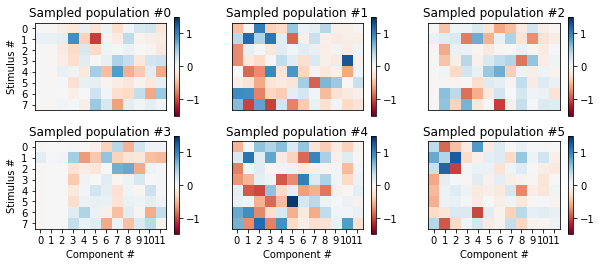

In [7]:
"""
Now, we collapse the time dimension by representing each component in each trial by the most 'extreme' value
it takes, i.e. the value furthest away from 0. We then normalize those values by subtracting the mean and
dividing by the std.

Then we plot the resulting values for a number of exemplary neuron samples. 
"""
def most_extreme_value(data):
    idx = numpy.argmax(numpy.abs(data), axis=0)
    return data[idx, range(len(idx))]

def ordered_stack(x, y, out_fun=numpy.array):
    idx = numpy.argsort(x)
    return out_fun([y[i] for i in idx])


def normalize(stim_labels, values):
    overall_mean = numpy.hstack(values).mean()
    overall_sd = numpy.hstack(values).std()
    for lbl, val in zip(stim_labels, values):
        yield (val - overall_mean) / overall_sd, {"stimulus": lbl}

exemplary_tribe = exemplary_tribes["Panel-B"]

data_points = comp_data.filter(**exemplary_tribe)

# Find for each component at each trial the most extreme value it takes through time (collapses the time steps)
ex_vol = data_points.map(most_extreme_value) # shape: n_repetitions
# Then normalize to mean / std across stimulus conditions
ex_vol = ex_vol.transform(['stimulus'], func=normalize, xy=True)
# Get mean of normalized value over repetitions
ex_vol = ex_vol.map(numpy.mean) # scalar value
# Pool the components into an array
ex_vol = ex_vol.pool(["component"], func=ordered_stack, xy=True) # components
# And pool these arrays for different stimuli into a 2d array
ex_vol = ex_vol.pool(["stimulus"],
                     func=lambda x, y: ordered_stack(x, y, out_fun=numpy.vstack), xy=True) # stim x component

fig = plt.figure(figsize=(10, 4))
for plt_idx, use_idx in enumerate(interesting_indices):
    ax = fig.add_subplot(2, 3, plt_idx + 1)
    ax.set_title("Sampled population #{0}".format(use_idx))
    img = ax.imshow(ex_vol.get2(index=use_idx), cmap="RdBu")
    img.set_clim([-1.5, 1.5])
    plt.colorbar(mappable=img, ax=ax)
    if plt_idx in [0, 3]:
        ax.set_yticks(range(num_stimuli))
        ax.set_ylabel("Stimulus #")
    else:
        ax.set_yticks([])
    if plt_idx in [3, 4, 5]:
        ax.set_xticks(range(num_components))
        ax.set_xlabel("Component #")
    else:
        ax.set_xticks([])
S.save(fig, fn="Panel-B")        


<ipython-input-8-63d1ece40de4>:6: RuntimeWarning: divide by zero encountered in log10
  return -numpy.log10(kruskal(*data_for_stims).pvalue)


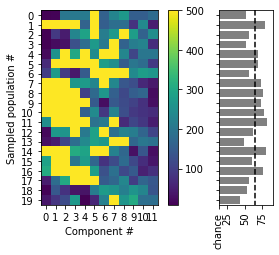

In [8]:
from scipy.stats import kruskal
exemplary_tribe = exemplary_tribes["Panel-C"]

def different_mean_for_different_stimuli_test(data_for_stims):
    try:
        return -numpy.log10(kruskal(*data_for_stims).pvalue)
    except:
        return 0.0

chance_level = 1.0 / num_stimuli

data_points = comp_data.filter(**exemplary_tribe) # (sampling, specifier, index, component, stimulus)
acc_points = accuracy_data.filter(**exemplary_tribe) # (sampling, specifier, index)

info_value = data_points.map(most_extreme_value) # shape: n_repetitions
info_value = info_value.pool(['stimulus'], different_mean_for_different_stimuli_test) # scalar
info_value = info_value.pool(['component'], func=ordered_stack, xy=True) # shape: components
info_value = info_value.pool(['index'], func=lambda x, y: ordered_stack(x, y, out_fun=numpy.vstack),
                            xy=True) # shape: index x components

mean_acc = acc_points.map(lambda x: numpy.nanmean(x)) # scalar; (sampling, specifier, index)
mean_acc = mean_acc.pool(['index'], func=ordered_stack, xy=True) # shape: index

def plot_general_assessment(I, acc):
    I[numpy.isinf(I)] = 500.0

    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_axes([0.15, 0.15, 0.6, 0.9])
    plt.colorbar(ax.imshow(I))
    ax.set_yticks(range(I.shape[0]))
    ax.set_xticks(range(I.shape[1]))
    ax.set_xlabel('Component #')
    ax.set_ylabel('Sampled population #')

    ax = fig.add_axes([0.8, 0.15, 0.15, 0.9])
    ax.barh(numpy.arange(len(acc)), acc, color='grey')
    ax.plot(numpy.mean(acc) * numpy.ones(2), [-0.5, len(acc) - 0.5], color='black', ls='--')
    ax.set_ylim([len(acc) - 0.5, -0.5])
    ax.set_xlim([chance_level, 0.9])
    ax.set_yticks(range(len(acc)))
    ax.set_yticklabels([])
    ax.set_xticks([chance_level, 0.25, 0.5, 0.75])  # Assuming chance level < 0.25
    ax.set_xticklabels(['chance', '25', '50', '75'], rotation='vertical')
    return fig

fig = plot_general_assessment(info_value.get2(),
                              mean_acc.get2())


In [9]:
score_read_fun = data.read_h5_dataset("scores")
y_read_fun = data.read_multiple_h5_datasets({"y_truth":"y_truth", "y_pred": "y_pred"})
y_data = data.TopoData(accuracy_fn,
                              follow_link_functions={"data_fn": [y_read_fun, True]})
y_data['data_fn'].contents[0].res

{'y_truth': array([4., 3., 5., ..., 7., 2., 7.]),
 'y_pred': array([0., 2., 5., ..., 7., 2., 7.])}